# Brain Tumor Detection with ResNET50
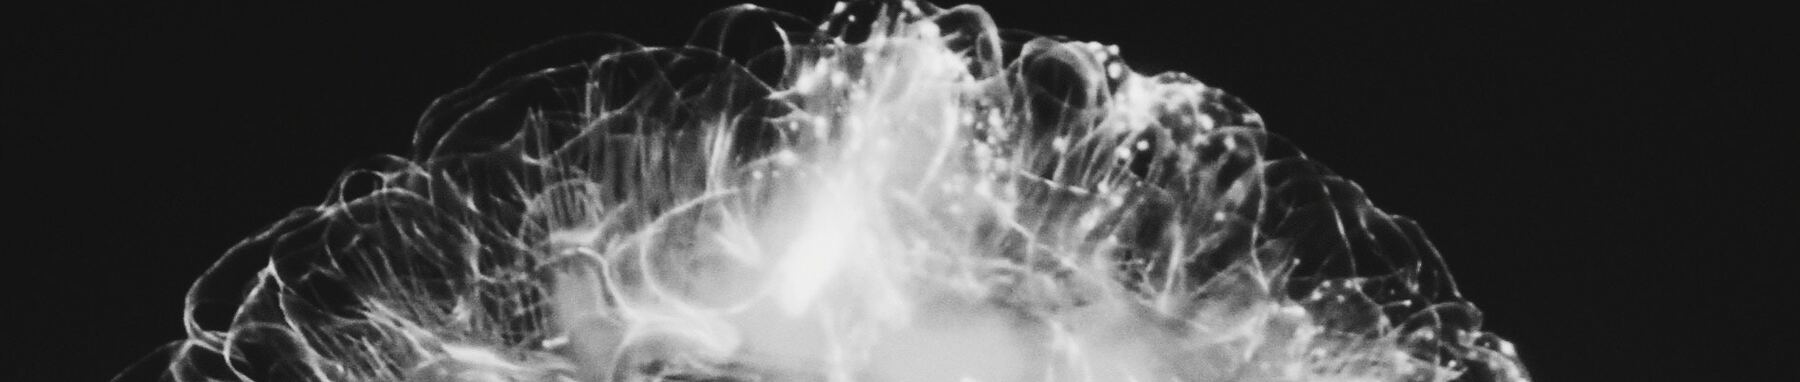

In [35]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers as tlf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization, ReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
import matplotlib.pyplot as plt
import splitfolders

np.random.seed(1)
tf.random.set_seed(42)

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [36]:
directory = 'brain_tumor_dataset/'

In [37]:
BATCH_SIZE = 32
IMG_SIZE = (124, 124)
train_dataset = image_dataset_from_directory(directory,
                                            shuffle = True,
                                            image_size = IMG_SIZE,
                                            validation_split = 0.2,
                                            subset = 'training',
                                            seed = 42)

validation_dataset = image_dataset_from_directory(directory,
                                            shuffle = True,
                                            image_size = IMG_SIZE,
                                            validation_split = 0.2,
                                            subset = 'validation',
                                            seed = 42)

Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [38]:
class_names = train_dataset.class_names

(124, 124, 3)
(124, 124, 3)
(124, 124, 3)
(124, 124, 3)
(124, 124, 3)
(124, 124, 3)
(124, 124, 3)
(124, 124, 3)
(124, 124, 3)


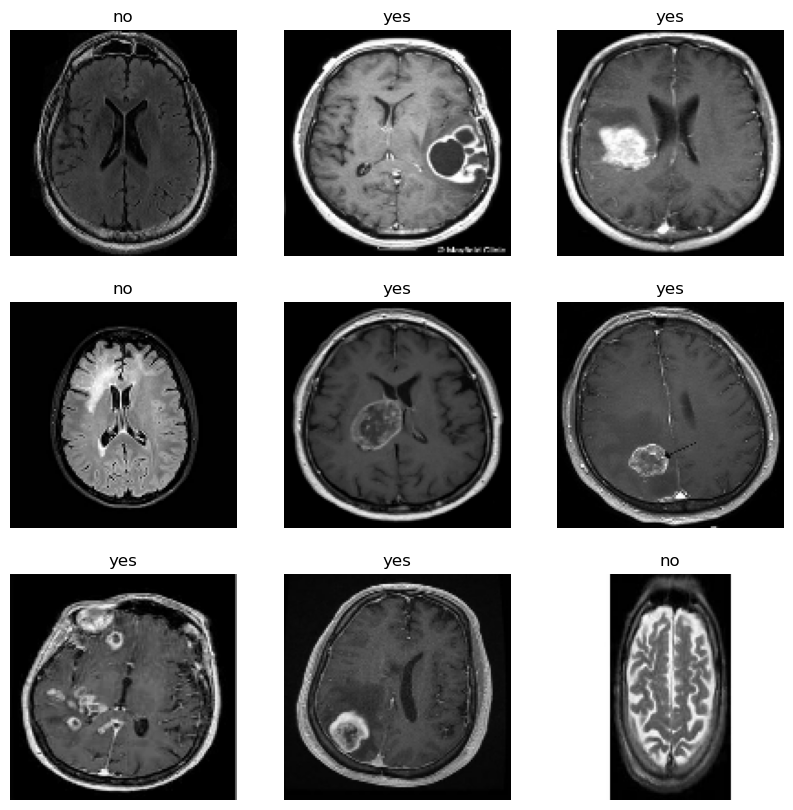

In [40]:
plt.figure(figsize=(10,10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        print(images[i].shape)
        plt.imshow(images[i]/255)
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [46]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
        RandomFlip('horizontal'),
        RandomFlip('vertical'),
        RandomRotation(0.2)
    ])
    return data_augmentation

In [47]:
data_augmentation = data_augmenter()

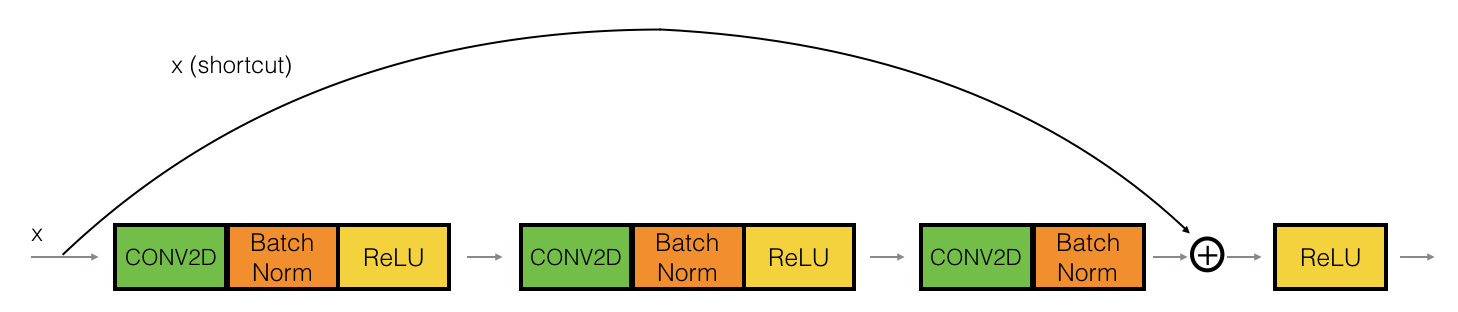



IMG-SHAPE = (124, 124, 3)

In [51]:
def identity_block(X, f, filters, initializer = random_uniform):
    
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    #build main path using TENSORFLOW FUNCTIONAL API LAYER IMPLEMENTATION
    #L1
    # First component of main path    
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed = 0))(X)
    X = BatchNormalization(axis = -1)(X)
    X = Activation('relu')(X)

    #L2
    # Second component of main path    
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed = 0))(X)
    X = BatchNormalization(axis = -1)(X)
    X = Activation('relu')(X) 

    #L3
    # Third component of main path    
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed = 0))(X)
    X = BatchNormalization(axis = -1)(X)

    #L4
    # Final Step with Shortcut   
    X = tf.keras.layers.Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [52]:
def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    """
    """
    #Retrieve Filters
    F1, F2, F3 = filters
    
    #save the input:
    X_shortcut = X
    
    ### Main Path ###
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [63]:
def ResNet50(input_shape = (124, 124, 3), classes = 2, training=False):
    """
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    X_input = data_augmenter()(X_input)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])


    
    # Use the instructions above in order to implement all of the Stages below
    # Make sure you don't miss adding any required parameter
    
    ## Stage 3 (≈4 lines)
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)

    # the 3 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512]) 

    # Stage 4 (≈6 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    
    # the 5 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024]) 

    # Stage 5 (≈3 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    
    # the 2 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D()(X)"
    X = AveragePooling2D(pool_size=(2, 2))(X)
    


    # output layer
    X = Flatten()(X)
    X = Dense(1, activation='linear', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [64]:
tf.keras.backend.set_learning_phase(True)

model = ResNet50(input_shape = (124, 124, 3), classes = 2)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 124, 124, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 130, 130, 3)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_106 (Conv2D)         (None, 62, 62, 64)           9472      ['zero_padding2d_2[1][0]']    
                                                                                                  
 batch_normalization_106 (B  (None, 62, 62, 64)           256       ['conv2d_106[1][0]']    

 batch_normalization_114 (B  (None, 30, 30, 64)           256       ['conv2d_114[1][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_105 (Activation  (None, 30, 30, 64)           0         ['batch_normalization_114[1][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_115 (Conv2D)         (None, 30, 30, 64)           36928     ['activation_105[1][0]']      
                                                                                                  
 batch_normalization_115 (B  (None, 30, 30, 64)           256       ['conv2d_115[1][0]']          
 atchNormalization)                                                                               
          

                                                                     'activation_110[1][0]']      
                                                                                                  
 activation_113 (Activation  (None, 15, 15, 512)          0         ['add_36[1][0]']              
 )                                                                                                
                                                                                                  
 conv2d_124 (Conv2D)         (None, 15, 15, 128)          65664     ['activation_113[1][0]']      
                                                                                                  
 batch_normalization_124 (B  (None, 15, 15, 128)          512       ['conv2d_124[1][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_133 (B  (None, 8, 8, 1024)           4096      ['conv2d_133[1][0]']          
 atchNormalization)                                                                               
                                                                                                  
 add_39 (Add)                (None, 8, 8, 1024)           0         ['batch_normalization_132[1][0
                                                                    ]',                           
                                                                     'batch_normalization_133[1][0
                                                                    ]']                           
                                                                                                  
 activation_122 (Activation  (None, 8, 8, 1024)           0         ['add_39[1][0]']              
 )        

                                                                                                  
 conv2d_142 (Conv2D)         (None, 8, 8, 1024)           263168    ['activation_130[1][0]']      
                                                                                                  
 batch_normalization_142 (B  (None, 8, 8, 1024)           4096      ['conv2d_142[1][0]']          
 atchNormalization)                                                                               
                                                                                                  
 add_42 (Add)                (None, 8, 8, 1024)           0         ['batch_normalization_142[1][0
                                                                    ]',                           
                                                                     'activation_128[1][0]']      
                                                                                                  
 activatio

 )                                                                  ]']                           
                                                                                                  
 conv2d_151 (Conv2D)         (None, 4, 4, 2048)           1050624   ['activation_139[1][0]']      
                                                                                                  
 conv2d_152 (Conv2D)         (None, 4, 4, 2048)           2099200   ['activation_137[1][0]']      
                                                                                                  
 batch_normalization_151 (B  (None, 4, 4, 2048)           8192      ['conv2d_151[1][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_152 (B  (None, 4, 4, 2048)           8192      ['conv2d_152[1][0]']          
 atchNorma

Total params: 23595905 (90.01 MB)
Trainable params: 23542785 (89.81 MB)
Non-trainable params: 53120 (207.50 KB)
__________________________________________________________________________________________________
None


In [82]:

np.random.seed(1)
tf.random.set_seed(2)
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
los = tf.keras.losses.BinaryCrossentropy(from_logits = True)
model.compile(optimizer=opt, loss=los, metrics=['accuracy'])

In [83]:
model.fit(train_dataset, epochs = 10, batch_size = 32)

Epoch 1/10
7/7 [==============================] - 53s 4s/step - loss: 0.4647 - accuracy: 0.7734
Epoch 2/10
7/7 [==============================] - 26s 4s/step - loss: 0.4378 - accuracy: 0.7833
Epoch 3/10
7/7 [==============================] - 26s 4s/step - loss: 0.5240 - accuracy: 0.7537
Epoch 4/10
7/7 [==============================] - 26s 4s/step - loss: 0.5743 - accuracy: 0.7488
Epoch 5/10
7/7 [==============================] - 25s 4s/step - loss: 0.4863 - accuracy: 0.7488
Epoch 6/10
7/7 [==============================] - 25s 3s/step - loss: 0.5393 - accuracy: 0.7488
Epoch 7/10
7/7 [==============================] - 25s 4s/step - loss: 0.4653 - accuracy: 0.7734
Epoch 8/10
7/7 [==============================] - 25s 4s/step - loss: 0.4736 - accuracy: 0.7685
Epoch 9/10
7/7 [==============================] - 25s 3s/step - loss: 0.4979 - accuracy: 0.7833
Epoch 10/10
7/7 [==============================] - 25s 4s/step - loss: 0.5108 - accuracy: 0.7537


In [84]:
preds = model.evaluate(validation_dataset)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

2/2 [==============================] - 3s 422ms/step - loss: 1.1001 - accuracy: 0.7800
Loss = 1.1001038551330566
Test Accuracy = 0.7799999713897705
